## Neural Network Quantization

---

### Before we begin...

For a well-rounded understanding of this topic, I highly recommend the lectures [TinyML and Efficient Deep Learning Computing by MiT HAN.LAb](https://hanlab.mit.edu/courses/2024-fall-65940). This is a fantastic course made by a world-level expert, Professor Song Han from MIT EECS. Although you will be able to understanding all the approaches I present in the repository, it  will be more effective to supplement the samples with a detailed explanation of the topic. 

Broadly speaking, quantization is a technique that converts a neural network from high-precision arithmetic (like 32-bit floating point) to low-precision (like 8-bit integers). This process addresses several critical needs in production deployment:

1. __Faster Inference__: Low-precision operations are computationally cheaper and can be heavily optimized on modern hardware.
2. __Smaller Model Size__: Reduced precision drastically cuts storage requirements, enabling deployment on resource-constrained devices.
3. __Lower Energy Consumption and Carbon Footprint__: Efficient computation and reduced memory bandwidth directly translate to less power usage, which is crucial at a global scale.

As a result, quantization enables:
1. Efficient execution on specific hardware, especially on edge devices with limited resources.
2. A carefully managed trade-off between model accuracy and computational efficiency.

### Remember!

A fundamental principle in computer architecture and performance optimization is:
> *Compute is cheap, memory access is expensive*.

In other words, the cost of moving data between different levels of memory (e.g., from RAM to cache levels) often dominates performance. 
Minimizing this data transfer is a cornerstone of efficient algorithm and system design.

Moreover, quantization is an application-oriented research topic that is highly driven by the needs of the computing industry. It is deeply interconnected with many other computer science disciplines, from hardware design to compiler theory.

---

## Asymmetric (Affine) Linear Quantization

In this notebook we will go through asymmetric linear quantization steps. Our goal is to compress ML model from __32-bit floating point__ precision to a __lower one__ preserving the most of the model acuracy.

Quantization approach helps to reduce excessive use of memory to store, read and apply ML models.

__Linear Quantization__ suggests that we can store quantized model weights along with small amount of parameters that helps to restore quantized weights as much as possible into the original form with higher bit precision via set of linear operations. The simplest way to do that is to store some scaling coefficients and track zero point between higher and lower precision weights.

*Note: we can quantize not only weights but __activations__ as well, we will cover some algorithms working with activations quantization in further examples.* 

In __Asymmetric Linear quantization__ we track quantized weights __scaling coefficients__ and __zero point__ location for a quantized range of values

In [1]:
import copy

import numpy as np
import torch
import torchao
import torch.nn as nn
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import datasets

import pandas as pd

import matplotlib.pyplot as plt
from watermark import watermark

%config InlineBackend.figure_format = "retina"

In [2]:
print(watermark())
print(watermark(packages="numpy,torch,torchvision,sklearn,matplotlib"))

Last updated: 2025-10-26T21:05:21.834463+03:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.6.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.14.0-33-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

numpy      : 2.3.4
torch      : 2.9.0
torchvision: 0.24.0
sklearn    : 1.7.2
matplotlib : 3.10.7



### Example 1. Wine classifier with dense neural network

In this example we will use [wine](https://archive.ics.uci.edu/dataset/109/wine) tabular dataset and a dense neural network to classify types of wine

In [3]:
seed = 123
test_size = 0.2

np.random.seed(seed)
data = datasets.load_wine()

X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

enc = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [4]:
print(X_train_sc.shape, y_train_enc.shape)

(142, 13) (142, 3)


### 1.1 Example: Numpy implementation

#### Preparing neural network classifier

In [5]:
class NNet:
    def __init__(
        self, 
        input_size: int, 
        hidden_size: int, 
        output_size: int
    ):
        # input_size, number of features in our dataset
        # hidden_size, hidden feature vector
        # output_size, the number of classes in our task
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.init_weights()

    def init_weights(self) -> None:
        # First layer with bias
        self.W1 = np.random.randn(input_size, hidden_size).astype(np.float32)
        self.b1 = np.random.randn(1, hidden_size).astype(np.float32)
        
        # Second layer with bias
        self.W2 = np.random.randn(hidden_size, output_size).astype(np.float32)
        self.b2 = np.random.randn(1, output_size).astype(np.float32)

    def forward(self, X: np.ndarray) -> np.ndarray:

        # Apply weights: z1 = W1X + b1
        self.z1 = np.dot(X, self.W1) + self.b1
        # Apply ReLU activation function: a1 = relu(z1)
        self.a1 = np.maximum(0, self.z1)
        # Apply weights: z2 = W2a1 + b2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        # Aply softmax activation: a2 = softmax(z2)
        exp_z2 = np.exp(self.z2)
        self.a2 = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)
        return self.a2

    def backward(self, X: np.ndarray, y: np.ndarray, learning_rate: float) -> None:
        """
        Lets write details how we actually calculate derivates for our model.
        
        L- loss function, the result of our forward calculation.
        
        dL/dz2 = a2 - y
        
            dL/dW2 = dL/dz2 * dz2/dW2 = (a2 - y) * a1
            dL/db2 = dL/dz2 * dz2/db2 = (a2 - y) * 1

            dL/da1 = dL/dz2 * dz2/da1 = (a2 - y) * W2

                dL/dz1 = dL/da1 * da1/dz1 =  (a2 - y) * W2 * 1_(z1 > 0)

                    dL/dW1 = dL/dz1 * dz1/dW1 = (a2 - y) * W2 * 1_(z1 > 0) * X
                    dL/db1 = dL/dz1 * dz1/db1 = (a2 - y) * W2 * 1_(z1 > 0)
        """
        m = X.shape[0]

        dz2 = self.a2 - y                                  # dL/dz2 
        dW2 = np.dot(self.a1.T, dz2) / m                   # dL/dW2
        db2 = np.sum(dz2, axis=0, keepdims=True) / m       # dL/db2 
        da1 = np.dot(dz2, self.W2.T)                       # dL/da1
        
        dz1 = da1 * (self.z1 > 0)                          # dL/dz1, Gradient for ReLU with indicator
        dW1 = np.dot(X.T, dz1) / m                         # dL/dW1
        db1 = np.sum(dz1, axis=0, keepdims=True) / m       # dL/db1

        # Update weights with fixed learning_rate with respect to their derivatives
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

In [6]:
# Set model parameters
n_features = X.shape[1]             # 13 features, 13 table columns
input_size = n_features             # Features are our input size of one sample
hidden_size = 100                   # Hidden size is our hidden dimension. 
output_size = len(np.unique(y))     # Output size is defined via our categories

# Set model training configuration
epochs = 200     # Total epochs
batch_size = 10  # How many samples we use in a mini-batch training
lr = 0.1         # Learning rate is constant for simplicity
eps = 1e-8       # Constant for numerical stability
show_epochs = 10 # For verbose output
train_size = len(y_train)

Lets train our classifier

In [7]:
model = NNet(input_size, hidden_size, output_size)

In [8]:
model_info = {
    "W1": model.W1.shape,
    "b1": model.b1.shape,
    "W2": model.W2.shape,
    "b2": model.b2.shape,
}
print("Model info:\n" + "".join([f"dim({k}): {v}\n" for k, v in model_info.items()]))

Model info:
dim(W1): (13, 100)
dim(b1): (1, 100)
dim(W2): (100, 3)
dim(b2): (1, 3)



In [9]:
model.init_weights()

loss_log = []

for epoch in range(epochs):
  loss_accum = 0
  for i in range(0, train_size, batch_size):
    X_batch = X_train_sc[i: i + batch_size, :]
    y_batch = np.array(y_train_enc[i: i + batch_size, :].todense())

    y_pred = model.forward(X_batch)
    ce_loss = -np.mean( np.sum(np.multiply(y_batch, np.log(y_pred + eps)), axis=1) )
    model.backward(X_batch, y_batch, lr)
    loss_accum += ce_loss
  loss_log.append(loss_accum)
  if epoch % show_epochs == 0:
    print(f"Epoch: {epoch}. Train loss: {loss_accum}")

Epoch: 0. Train loss: 34.80452084764922
Epoch: 10. Train loss: 0.001660566730564671
Epoch: 20. Train loss: 0.0009475190943517911
Epoch: 30. Train loss: 0.0006958735681107859
Epoch: 40. Train loss: 0.0005595339075997498
Epoch: 50. Train loss: 0.0004725040701494334
Epoch: 60. Train loss: 0.00041178088309021623
Epoch: 70. Train loss: 0.0003669436213747717
Epoch: 80. Train loss: 0.00033249625635077925
Epoch: 90. Train loss: 0.00030524011818419103
Epoch: 100. Train loss: 0.0002831695550347456
Epoch: 110. Train loss: 0.00026495946563865377
Epoch: 120. Train loss: 0.00024970139180467975
Epoch: 130. Train loss: 0.00023674328596567416
Epoch: 140. Train loss: 0.00022561188672422084
Epoch: 150. Train loss: 0.0002159467793310257
Epoch: 160. Train loss: 0.00020747418316025893
Epoch: 170. Train loss: 0.00019998341468951841
Epoch: 180. Train loss: 0.00019330689638822222
Epoch: 190. Train loss: 0.00018731311547128917


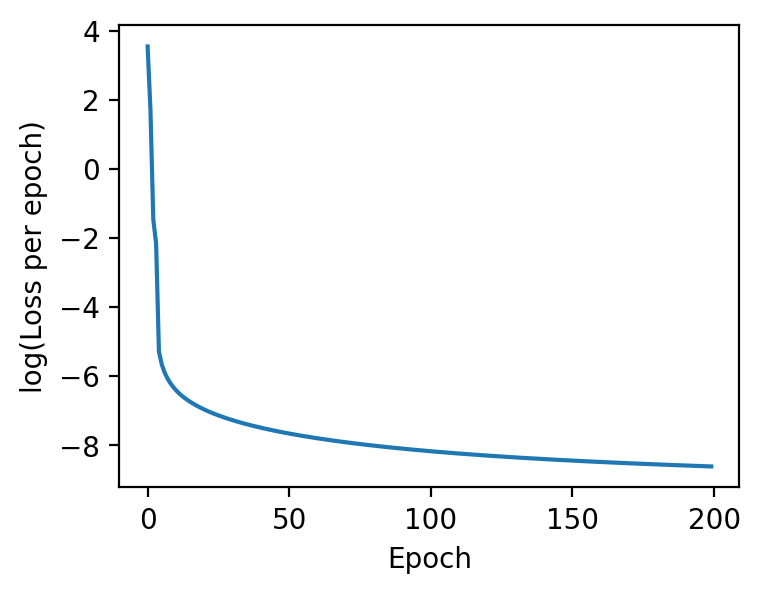

In [10]:
fig = plt.figure(figsize=(4 ,3))
plt.plot(np.log(loss_log))
plt.xlabel("Epoch")
plt.ylabel("log(Loss per epoch)")
plt.show()

Evaluate model on a test set

In [11]:
y_pred_test = np.argmax(model.forward(X_test_sc), axis=1)
print(classification_report(y_test, y_pred_test, target_names=data.target_names))  

              precision    recall  f1-score   support

     class_0       0.89      1.00      0.94         8
     class_1       0.91      0.91      0.91        11
     class_2       1.00      0.94      0.97        17

    accuracy                           0.94        36
   macro avg       0.93      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36



Everybody wishes to get such metrics on a real data 😄

Now when we have the prepared model we can apply quantization. But before doing that lets measure current model storage assuming that we have 32-bit floating point weights:

In [12]:
def calculate_model_storage(model_obj: object, num_bits: int) -> int:
    """
    Calculate the total storage size of a model in bytes.
    NB!!! Without storage need for metadata: scaling coefficients and zero point

    Parameters:
        model (NNet): The neural network model with weights and biases.
        num_bits (int): The bit precision (e.g., 32 for FP32, 8 for INT8).

    Returns:
        int: Total storage size in bytes.
    """
    total_params = 0

    # Count parameters for each layer
    total_params += np.prod(model_obj.W1.shape) + np.prod(model_obj.b1.shape)
    total_params += np.prod(model_obj.W2.shape) + np.prod(model_obj.b2.shape)

    # Calculate storage in bytes
    total_bits = total_params * num_bits
    total_bytes = total_bits // 8

    return total_bytes

In [13]:
print(f"Initial model size is {calculate_model_storage(model, 32) / 1024:.2f}KB")

Initial model size is 6.65KB


We will store this information for further comparison

In [14]:
initial_report = classification_report(y_test, y_pred_test, target_names=data.target_names, output_dict=True)

In [15]:
METRICS = [
    (
        "fp32",
        float(initial_report["macro avg"]["f1-score"]),
        float(initial_report["macro avg"]["recall"]),
        float(initial_report["macro avg"]["precision"]),
        calculate_model_storage(model, 32) / 1024, # Weights size in KB
        0, # Quantization squared error
    ) 
]

#### Apply quantization


We will stick to the following procedure to pick the best model from the quantized candidates:

1. Apply initial cross-layer equalization, CLE
2. Apply linear quantization
3. Calculate quantization error as MSE between initial FP32 weights and dequantized weights calculated from lower precision
4. Evaluate model storage and accuracy

*Note: CLE is another topic closely related to qunatization procedures. You can learn more in paper [Data-Free Quantization
Through Weight Equalization and Bias Correction](https://arxiv.org/pdf/1906.04721)*

In [16]:
weights_preicions_in_bits = (8, 6, 4, 2)

In [17]:
def cross_layer_equalization(W1: np.ndarray, W2: np.ndarray, b1: np.ndarray) -> tuple:
    """
    Normalize the weights across two consecutive layers to balance their scales.
    Adjusts W1, W2, and b1 in place to equalize the activation ranges.
    """
    # We use weights dimension order (in_features, out_features) in this simple setting.
    r1 = np.max(np.abs(W1), axis=0)  # Max abs values in W1, axis=1 means we aggregate values across inputs
    r2 = np.max(np.abs(W2), axis=1)  # Max abs values in W2, axis=0 means we aggregate values across outputs

    s = r1 / (r2 + 1e-8)
    # print(f"CLE scaling factors: {s}")
    
    for i in range(W1.shape[1]):
        W1[:, i] = W1[:, i] / s[i]
        b1[0][i] = b1[0][i] / s[i]
        W2[i, :] = W2[i, :] * s[i]

    return W1, W2, b1
     

def quantize_tensor(tensor: np.ndarray, num_bits: int) -> tuple:
    """
    Apply asymmetric linear quantization
    """

    qmin = -(2 ** (num_bits - 1))     # Minimum value in quantized range
    qmax = (2 ** (num_bits - 1)) - 1. # Maximum value in quantized range

    min_val = np.min(tensor)          # Minimum real value of a tensor
    max_val = np.max(tensor)          # Maximum real value of a tensor

    scale = (max_val - min_val) / (qmax - qmin) # Scaling factor
    zero_point = qmin - min_val / scale         # Zero point location for a quantized range

    # These matrices can be stored along with scaling factors and zero point for dequantization
    quantized = np.round(zero_point + tensor / scale).clip(qmin, qmax).astype(int)
    dequantized = scale * (quantized - zero_point)

    return quantized, dequantized, scale, zero_point


def get_quant_mse(x1: np.ndarray, x2: np.ndarray, precision: int = 4) -> float:
  return np.round(np.sum( (x1 - x2)**2), precision)

In [18]:
for bits in weights_preicions_in_bits:

  print(f"### Qunatization with Bits: {bits}")

  model_quantized = copy.deepcopy(model)

  # Step 1: Apply CLE
  W1, W2, b1 = cross_layer_equalization(model_quantized.W1, model_quantized.W2, model_quantized.b1)
  b2 = model_quantized.b2

  # Step 2: Quantize weights and biases of the model
  q_W1, dq_W1, scale_W1, zp_W1 = quantize_tensor(W1, bits)
  q_b1, dq_b1, scale_b1, zp_b1 = quantize_tensor(b1, bits)
  q_W2, dq_W2, scale_W2, zp_W2 = quantize_tensor(W2, bits)
  q_b2, dq_b2, scale_b2, zp_b2 = quantize_tensor(b2, bits)
  print(f"#Original FP32 W1:\n{W1}\n#Quantized W1 with {bits} bits:\n{q_W1}\n#Dequantized W1:\n{dq_W1}")
  quant_mse = np.round(get_quant_mse(dq_W1, W1) + get_quant_mse(dq_W2, W2) + get_quant_mse(dq_b2, b2) + get_quant_mse(dq_b1, b1), 4)
  print(f"Quantization MSE: {quant_mse}")

  # Step 3: Assign new weights to the model
  model_quantized.W1 = dq_W1
  model_quantized.b1 = dq_b1
  model_quantized.W2 = dq_W2
  model_quantized.b2 = dq_b2

  storage_kb = calculate_model_storage(model, num_bits=bits) / 1024
  print(f"INT{bits} Model Storage: {storage_kb :.2f} KB")
  y_pred_test_quant = np.argmax(model_quantized.forward(X_test_sc), axis=1)
  report = classification_report(y_test, y_pred_test_quant, target_names=data.target_names)
  report_dict = classification_report(y_test, y_pred_test_quant, target_names=data.target_names, output_dict=True)
  print(report)

  METRICS.append(
      (
              f"Q_{bits}bit", 
              float(report_dict["macro avg"]["f1-score"]),
              float(report_dict["macro avg"]["recall"]),
              float(report_dict["macro avg"]["precision"]),
              float(storage_kb),
              float(quant_mse),
    )
  )

### Qunatization with Bits: 8
#Original FP32 W1:
[[-0.5420247  -0.17215796 -0.4775285  ... -0.23556532 -0.16103874
  -0.1501477 ]
 [ 0.15514757  0.37640822 -0.8304614  ...  0.03485452  0.00406086
  -0.10569131]
 [ 1.5605261   0.42767206  0.06610699 ... -1.1828731  -0.28799695
   0.57866275]
 ...
 [ 0.38066596  0.3469791   0.19245772 ... -0.7721957  -0.17893527
  -0.497879  ]
 [-1.321151    0.8399943   0.5546144  ...  0.18353902  0.07889172
   0.2625545 ]
 [-0.46748447 -0.465602   -0.02235018 ... -0.30418375  0.14572665
   0.64380074]]
#Quantized W1 with 8 bits:
[[-32 -15 -29 ... -18 -14 -14]
 [  1  11 -46 ...  -5  -6 -12]
 [ 68  14  -3 ... -63 -20  21]
 ...
 [ 12  10   3 ... -43 -15 -30]
 [-69  33  20 ...   2  -3   6]
 [-29 -29  -8 ... -21   0  24]]
#Dequantized W1:
[[-0.53670628 -0.17849387 -0.47349233 ... -0.24170782 -0.15742255
  -0.15742255]
 [ 0.15864723  0.36936041 -0.83170474 ...  0.03221932  0.011148
  -0.11527991]
 [ 1.57042557  0.43257437  0.07436196 ... -1.18991716 -0.283850

In [19]:
METRICS

[('fp32',
  0.9399881164587046,
  0.9500891265597149,
  0.9326599326599326,
  np.float64(6.65234375),
  0),
 ('Q_8bit',
  0.9399881164587046,
  0.9500891265597149,
  0.9326599326599326,
  1.6630859375,
  0.0616),
 ('Q_6bit',
  0.9399881164587046,
  0.9500891265597149,
  0.9326599326599326,
  1.2470703125,
  0.992),
 ('Q_4bit',
  0.9645191409897292,
  0.9696969696969697,
  0.9629629629629629,
  0.8310546875,
  18.1014),
 ('Q_2bit',
  0.8141471642420409,
  0.8275401069518716,
  0.8119658119658121,
  0.4150390625,
  566.2275)]

In [20]:
df_results = pd.DataFrame(METRICS, columns=["Weights", "macro_avg_f1", "macro_avg_recall", "macro_avg_precision", "Kb", "MSE"])
# Simple efficiency metric
# It shows how much model accuracy nominated in `macro_avg_f1` we store per one Kb of the model storage
df_results["macro_avg_f1_per_Kb"] = df_results["macro_avg_f1"] / df_results["Kb"]

In [21]:
df_results

,Weights,macro_avg_f1,macro_avg_recall,macro_avg_precision,Kb,MSE,macro_avg_f1_per_Kb
0,fp32,0.939988,0.950089,0.932660,6.652344,0.0000,0.141302
1,Q_8bit,0.939988,0.950089,0.932660,1.663086,0.0616,0.565207
2,Q_6bit,0.939988,0.950089,0.932660,1.247070,0.9920,0.753757
3,Q_4bit,0.964519,0.969697,0.962963,0.831055,18.1014,1.160596
4,Q_2bit,0.814147,0.827540,0.811966,0.415039,566.2275,1.961616


On top of that, we should keep the following linear coefficients for later weights dequantization during inference:

In [22]:
linear_coefficients = {
    "scale_W1": scale_W1,
    "zp_W1": zp_W1,
    "scale_b1": scale_b1,
    "zp_b1": zp_b1,
    "scale_W2": scale_W2,
    "zp_W2": zp_W2,
    "scale_b2": scale_b2,
    "zp_b2": zp_b2
}
linear_coefficients

{'scale_W1': np.float32(1.791062),
 'zp_W1': np.float32(-0.57093),
 'scale_b1': np.float32(1.5382051),
 'zp_b1': np.float32(-0.6835902),
 'scale_W2': np.float32(1.9245272),
 'zp_W2': np.float32(-0.60532856),
 'scale_b2': np.float32(0.9522776),
 'zp_b2': np.float32(0.15996909)}

Choosing the best model depends on the specific requirements of your task. 

For example, if we want to balance model accuracy described via `macro_avg_f1` and model storage efficiency, we can pick `Q_4bit` solution. 

If we need the fastest model possible with minimum memory consumption for resource-constrained electronics, `Q_2bit` is our choice.

That's it! We created a wine classifier with Numpy from scratch and applied asymmetric linear quantization!

### 1.2 Example: Pytorch implementation

#### Preparing neural network classifier

In [126]:
class NNetTorch(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(NNetTorch, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size, bias=True)
        self.layer2 = nn.Linear(hidden_size, output_size, bias=True)
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z1 = self.layer1(x)
        a1 = self.relu(z1)
        z2 = self.layer2(a1)
        return z2        

In [127]:
torch.manual_seed(seed)

# Set model parameters
n_features = X.shape[1]             # 13 features, 13 table columns
input_size = n_features             # Features are our input size of one sample
hidden_size = 100                   # Hidden size is our hidden dimension. 
output_size = len(np.unique(y))     # Output size is defined via our categories

# Set model training configuration
epochs = 200     # Total epochs
batch_size = 10  # How many samples we use in a mini-batch training
lr = 0.1         # Learning rate is constant for simplicity
eps = 1e-8       # Constant for numerical stability
show_epochs = 10 # For verbose output
train_size = len(y_train)
device = "cpu"

In [128]:
model_torch = NNetTorch(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_torch.parameters(), lr=lr)

loss_log = []

for epoch in range(epochs):
  loss_accum = 0
  for i in range(0, train_size, batch_size):
      
    X_batch = X_train_sc[i: i + batch_size, :]
    y_batch = np.array(y_train_enc[i: i + batch_size, :].todense())
    X_batch = torch.tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)

    optimizer.zero_grad()
      
    y_pred = model_torch.forward(X_batch)
    
    loss = criterion(y_pred, y_batch)
    loss.backward()

    optimizer.step()
    
    loss_accum += loss
      
  loss_log.append(float(loss_accum.detach().numpy()))
  if epoch % show_epochs == 0:
    print(f"Epoch: {epoch}. Train loss: {loss_accum}")

Epoch: 0. Train loss: 9.005224227905273
Epoch: 10. Train loss: 0.4637968838214874
Epoch: 20. Train loss: 0.2039313018321991
Epoch: 30. Train loss: 0.12359452247619629
Epoch: 40. Train loss: 0.08653610199689865
Epoch: 50. Train loss: 0.06568372249603271
Epoch: 60. Train loss: 0.05258850008249283
Epoch: 70. Train loss: 0.04365142062306404
Epoch: 80. Train loss: 0.037142105400562286
Epoch: 90. Train loss: 0.03222281485795975
Epoch: 100. Train loss: 0.02839748002588749
Epoch: 110. Train loss: 0.02533889375627041
Epoch: 120. Train loss: 0.022840632125735283
Epoch: 130. Train loss: 0.02076141908764839
Epoch: 140. Train loss: 0.01901182532310486
Epoch: 150. Train loss: 0.017512481659650803
Epoch: 160. Train loss: 0.016218826174736023
Epoch: 170. Train loss: 0.01508971955627203
Epoch: 180. Train loss: 0.01409891713410616
Epoch: 190. Train loss: 0.013219804503023624


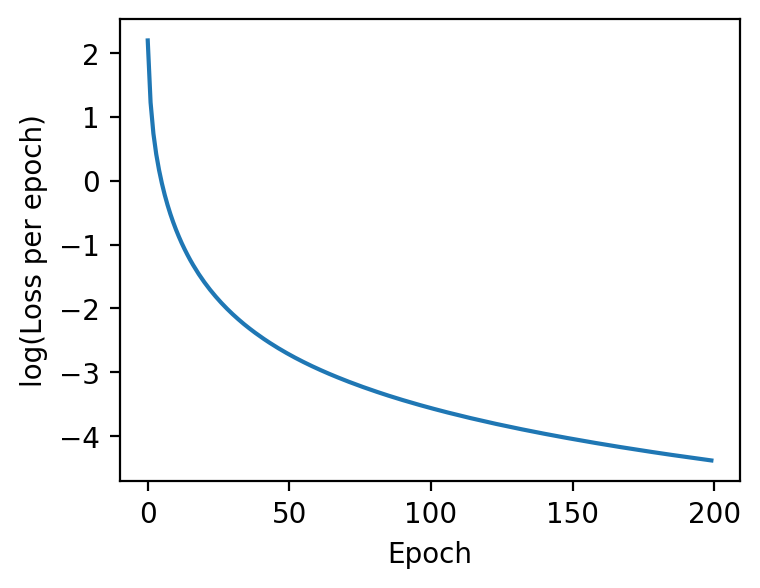

In [129]:
fig = plt.figure(figsize=(4 ,3))
plt.plot(np.log(loss_log))
plt.xlabel("Epoch")
plt.ylabel("log(Loss per epoch)")
plt.show()

In [130]:
model_torch.eval()

y_pred_test = torch.argmax(model_torch.forward(torch.tensor(X_test_sc, dtype=torch.float32, )), axis=1)
print(classification_report(y_test, y_pred_test.numpy(), target_names=data.target_names))  

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00         8
     class_1       0.92      1.00      0.96        11
     class_2       1.00      0.94      0.97        17

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36



In [131]:
[x for x in model_torch.modules()]

[NNetTorch(
   (layer1): Linear(in_features=13, out_features=100, bias=True)
   (layer2): Linear(in_features=100, out_features=3, bias=True)
   (relu): ReLU()
 ),
 Linear(in_features=13, out_features=100, bias=True),
 Linear(in_features=100, out_features=3, bias=True),
 ReLU()]

In torch API we have model parameters representation `.weight` and `.bias` attributes in a layer object

In [132]:
layer1_module = model_torch.get_submodule("layer1")
layer2_module = model_torch.get_submodule("layer2")
layer1_W, layer1_b = layer1_module.weight, layer1_module.bias
layer2_W, layer2_b = layer2_module.weight, layer2_module.bias

In [133]:
model_torch_info = {
    "W1": layer1_W.shape,
    "b1": layer1_b.shape,
    "W2": layer2_W.shape,
    "b2": layer2_b.shape,
}
print("Model info:\n" + "".join([f"dim({k}): {v}\n" for k, v in model_torch_info.items()]))

Model info:
dim(W1): torch.Size([100, 13])
dim(b1): torch.Size([100])
dim(W2): torch.Size([3, 100])
dim(b2): torch.Size([3])



__Note about weight shapes__

Let's recall that initial tabular data dimensions is `X.shape = (178, 13)` where 178 is the number of samples and 13 is the number of features in a dataset.

In Numpy implementation we have a *mathematical* way of tensor dimensions representation which is `[in_features, out_features]`:

    Model info:
    dim(W1): (13, 100)
    dim(b1): (1, 100)
    dim(W2): (100, 3)
    dim(b2): (1, 3)
    
In torch API dimensions order is `[out_features, in_features]`:

    Model info:
    dim(W1): torch.Size([100, 13])
    dim(b1): torch.Size([100])
    dim(W2): torch.Size([3, 100])
    dim(b2): torch.Size([3])

#### Apply quantization

#### torch.ao.quantization API

- __[October 2025]__
    * torch.ao API for quantization is available with `torch<2.10`. Starting from `torch==2.10` torchao will be the main API for these operations.
    * The details about API migration is in `DeprecationWarning` message

In torch<2.10 weight only quantization is mainly supported with dynamic quantization where we actually have uantization for the activations happening on-the-fly (“dynamic”) during inference.

In [134]:
model_torch_8bit_quantized = torch.quantization.quantize_dynamic(
    model=model_torch,  
    qconfig_spec={torch.nn.Linear}, 
    dtype=torch.qint8,
    inplace=False,
)

/tmp/ipykernel_38881/55647241.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_torch_8bit_quantized = torch.quantization.quantize_dynamic(


In [135]:
model_torch_8bit_quantized

NNetTorch(
  (layer1): DynamicQuantizedLinear(in_features=13, out_features=100, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer2): DynamicQuantizedLinear(in_features=100, out_features=3, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (relu): ReLU()
)

In [136]:
model_torch_8bit_quantized.eval()
y_pred_test = torch.argmax(model_torch_8bit_quantized.forward(torch.tensor(X_test_sc, dtype=torch.float32, )), axis=1)
print(classification_report(y_test, y_pred_test.numpy(), target_names=data.target_names))  

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00         8
     class_1       0.92      1.00      0.96        11
     class_2       1.00      0.94      0.97        17

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36



Now we quantize weights and activations. This is a static quantization which means we need to add quantize and dequantize operations into our model. To do that. we add `QuantStub` and `DeQuantStub` layers.

Note: About 100 mini-batches of representative data are sufficient to calibrate.

See details: https://docs.pytorch.org/docs/stable/quantization-support.html

In [137]:
model_torch_with_stubs = nn.Sequential(
    torch.quantization.QuantStub(), 
    model_torch, 
    torch.quantization.DeQuantStub()
)

model_torch_with_stubs.qconfig = torch.quantization.QConfig(
    activation=torch.quantization.MinMaxObserver.with_args(
        qscheme=torch.per_tensor_affine,  # Affine / Asymmetric
        dtype=torch.quint8,
        reduce_range=False
    ),
    weight=torch.quantization.MinMaxObserver.with_args(
        dtype=torch.qint8,
        qscheme=torch.per_tensor_affine  # Affine / Asymmetric
    )
)

model_torch_prepared = torch.quantization.prepare(model_torch_with_stubs, inplace=False)

# We need to calibrate our model a bit.
# It means that we should collect statistics about our input data distribution in order to properly modify activations. 
# Since we do not have calibration dataset, we will use scaled train susbet params to generate feature vectors.

N_calib = 100
with torch.no_grad():
    for _ in range(N_calib):
        sample_input = np.random.normal(loc=X_train_sc.mean(axis=0), scale=1.)
        tensor_input = torch.tensor(sample_input, dtype=torch.float32)
        model_torch_prepared(tensor_input)

model_torch_8bit_quantized = torch.quantization.convert(model_torch_prepared)

/tmp/ipykernel_38881/574239775.py:19: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_torch_prepared = torch.quantization.prepare(model_torch_with_stubs, inplace=False)
/tmp/ipykernel_38881/574239775.py:32: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.

In [138]:
model_torch_8bit_quantized

Sequential(
  (0): Quantize(scale=tensor([0.0271]), zero_point=tensor([130]), dtype=torch.quint8)
  (1): NNetTorch(
    (layer1): QuantizedLinear(in_features=13, out_features=100, scale=0.024561908096075058, zero_point=123, qscheme=torch.per_tensor_affine)
    (layer2): QuantizedLinear(in_features=100, out_features=3, scale=0.07960879802703857, zero_point=103, qscheme=torch.per_tensor_affine)
    (relu): ReLU()
  )
  (2): DeQuantize()
)

In [139]:
model_torch_8bit_quantized.eval()
y_pred_test = torch.argmax(model_torch_8bit_quantized.forward(torch.tensor(X_test_sc, dtype=torch.float32)), axis=1)
print(classification_report(y_test, y_pred_test.numpy(), target_names=data.target_names))

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00         8
     class_1       0.92      1.00      0.96        11
     class_2       1.00      0.94      0.97        17

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36



#### torchao API

See: https://docs.pytorch.org/ao/stable/static_quantization.html

There are several predefined configs for torch models quantization as well as detailed examle in official torchao doc.

In [140]:
import torch.nn.functional as F
from dataclasses import dataclass

from torchao.quantization import Int8WeightOnlyConfig, Int4WeightOnlyConfig
from torchao.quantization import Int8DynamicActivationInt4WeightConfig
from torchao.quantization import Float8StaticActivationFloat8WeightConfig 

from torchao.core.config import AOBaseConfig
from torchao.quantization import quantize_
from torchao.quantization.quant_api import _replace_with_custom_fn_if_matches_filter
from torchao.dtypes import to_affine_quantized_intx_static
from torchao.quantization.observer import AffineQuantizedMinMaxObserver
from torchao.quantization.granularity import PerTensor, PerAxis
from torchao.quantization.quant_primitives import MappingType
from torchao.quantization.transform_module import register_quantize_module_handler

In [141]:
act_obs = AffineQuantizedMinMaxObserver(
    MappingType.ASYMMETRIC, # ASYMMETRIC or SYMMETRIC
    torch.uint8,
    granularity=PerTensor(),
    eps=torch.finfo(torch.float32).eps,
    scale_dtype=torch.float32,
    zero_point_dtype=torch.float32,
)

weight_obs = AffineQuantizedMinMaxObserver(
    MappingType.ASYMMETRIC,  # ASYMMETRIC or SYMMETRIC
    torch.uint8,
    granularity=PerAxis(axis=0),
    eps=torch.finfo(torch.float32).eps,
    scale_dtype=torch.float32,
    zero_point_dtype=torch.float32,
)

class ObservedLinear(torch.nn.Linear):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        act_obs: torch.nn.Module,
        weight_obs: torch.nn.Module,
        bias: bool = True,
        device=None,
        dtype=None,
    ):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.act_obs = act_obs
        self.weight_obs = weight_obs

    def forward(self, input: torch.Tensor):
        observed_input = self.act_obs(input)
        observed_weight = self.weight_obs(self.weight)
        return F.linear(observed_input, observed_weight, self.bias)

    @classmethod
    def from_float(cls, float_linear, act_obs, weight_obs):
        observed_linear = cls(
            float_linear.in_features,
            float_linear.out_features,
            act_obs,
            weight_obs,
            False,
            device=float_linear.weight.device,
            dtype=float_linear.weight.dtype,
        )
        observed_linear.weight = float_linear.weight
        observed_linear.bias = float_linear.bias
        return observed_linear

def insert_observers_(model, act_obs, weight_obs):
    _is_linear = lambda m, fqn: isinstance(m, torch.nn.Linear)

    def replacement_fn(m):
        copied_act_obs = copy.deepcopy(act_obs)
        copied_weight_obs = copy.deepcopy(weight_obs)
        return ObservedLinear.from_float(m, copied_act_obs, copied_weight_obs)

    _replace_with_custom_fn_if_matches_filter(model, replacement_fn, _is_linear)

In [142]:
model_torch_ao = copy.deepcopy(model_torch)
insert_observers_(model_torch_ao, act_obs, weight_obs)

In [144]:
model_torch_ao

NNetTorch(
  (layer1): ObservedLinear(
    in_features=13, out_features=100, bias=True
    (act_obs): AffineQuantizedMinMaxObserver()
    (weight_obs): AffineQuantizedMinMaxObserver()
  )
  (layer2): ObservedLinear(
    in_features=100, out_features=3, bias=True
    (act_obs): AffineQuantizedMinMaxObserver()
    (weight_obs): AffineQuantizedMinMaxObserver()
  )
  (relu): ReLU()
)

In [145]:
N_calib = 100
with torch.no_grad():
    for _ in range(N_calib):
        sample_input = np.random.normal(loc=X_train_sc.mean(axis=0), scale=1.)
        tensor_input = torch.tensor(sample_input, dtype=torch.float32)
        model_torch_ao(tensor_input)

In [146]:
class QuantizedLinear(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        act_obs: torch.nn.Module,
        weight_obs: torch.nn.Module,
        weight: torch.Tensor,
        bias: torch.Tensor,
        target_dtype: torch.dtype,
    ):
        super().__init__()
        self.act_scale, self.act_zero_point = act_obs.calculate_qparams()
        weight_scale, weight_zero_point = weight_obs.calculate_qparams()
        assert weight.dim() == 2
        block_size = (1, weight.shape[1])
        self.target_dtype = target_dtype
        self.bias = bias
        self.qweight = to_affine_quantized_intx_static(
            weight, weight_scale, weight_zero_point, block_size, self.target_dtype
        )

    def forward(self, input: torch.Tensor):
        block_size = input.shape
        qinput = to_affine_quantized_intx_static(
            input,
            self.act_scale,
            self.act_zero_point,
            block_size,
            self.target_dtype,
        )
        return F.linear(qinput, self.qweight, self.bias)

    @classmethod
    def from_observed(cls, observed_linear, target_dtype):
        quantized_linear = cls(
            observed_linear.in_features,
            observed_linear.out_features,
            observed_linear.act_obs,
            observed_linear.weight_obs,
            observed_linear.weight,
            observed_linear.bias,
            target_dtype,
        )
        return quantized_linear

In [147]:
@dataclass
class StaticQuantConfig(AOBaseConfig):
    target_dtype: torch.dtype

@register_quantize_module_handler(StaticQuantConfig)
def _apply_static_quant(
    module: torch.nn.Module,
    config: StaticQuantConfig,
):
    """
    Define a transformation associated with `StaticQuantConfig`.
    This is called by `quantize_`, not by the user directly.
    """
    return QuantizedLinear.from_observed(module, config.target_dtype)

# filter function to identify which modules to swap
is_observed_linear = lambda m, fqn: isinstance(m, ObservedLinear)

# perform static quantization
quantize_(model_torch_ao, StaticQuantConfig(torch.uint8), is_observed_linear)

In [149]:
model_torch_ao

NNetTorch(
  (layer1): QuantizedLinear()
  (layer2): QuantizedLinear()
  (relu): ReLU()
)

In [150]:
model_torch_ao.eval()
y_pred_test = torch.argmax(model_torch_ao.forward(torch.tensor(X_test_sc, dtype=torch.float32)), axis=1)
print(classification_report(y_test, y_pred_test.numpy(), target_names=data.target_names))  

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00         8
     class_1       0.92      1.00      0.96        11
     class_2       1.00      0.94      0.97        17

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36



In [152]:
model_torch_ao.get_submodule("layer1").qweight

AffineQuantizedTensor(tensor_impl=PlainAQTTensorImpl(data=tensor([[ 70, 128,  49,  ...,  83, 200,   3],
        [  0,  36,  83,  ..., 255,  57, 133],
        [ 53, 234, 243,  ...,  22, 116,  23],
        ...,
        [119, 167, 233,  ...,  39,   0, 223],
        [180,  92, 111,  ..., 220, 145,   0],
        [ 25,  66,  17,  ..., 242, 140,   5]], dtype=torch.uint8)... , scale=tensor([0.0018, 0.0022, 0.0020, 0.0017, 0.0024, 0.0022, 0.0026, 0.0025, 0.0021,
        0.0021, 0.0012, 0.0020, 0.0020, 0.0022, 0.0022, 0.0022, 0.0030, 0.0017,
        0.0023, 0.0018, 0.0027, 0.0036, 0.0027, 0.0019, 0.0019, 0.0020, 0.0024,
        0.0016, 0.0019, 0.0019, 0.0022, 0.0024, 0.0024, 0.0022, 0.0023, 0.0026,
        0.0024, 0.0024, 0.0014, 0.0026, 0.0019, 0.0020, 0.0022, 0.0021, 0.0021,
        0.0031, 0.0025, 0.0022, 0.0020, 0.0023, 0.0016, 0.0015, 0.0027, 0.0023,
        0.0023, 0.0018, 0.0024, 0.0029, 0.0026, 0.0025, 0.0023, 0.0028, 0.0023,
        0.0016, 0.0031, 0.0020, 0.0024, 0.0022, 0.0022, 0.0020

In [153]:
model_torch_ao.get_submodule("layer1").bias

Parameter containing:
tensor([-0.1813,  0.1357,  0.2624,  0.3053,  0.0892,  0.1623,  0.2179,  0.3732,
        -0.2232,  0.1446, -0.1695, -0.0876, -0.2863, -0.1848,  0.2870, -0.0086,
         0.2643, -0.2374,  0.0596,  0.1793,  0.1847,  0.2727,  0.3992, -0.2607,
        -0.1017, -0.1991,  0.1971, -0.0128, -0.0442,  0.1727,  0.0953,  0.2078,
        -0.0858, -0.0805,  0.1546, -0.0710,  0.1670, -0.0221,  0.1278, -0.1898,
        -0.1591, -0.0521,  0.1075, -0.0577,  0.2702,  0.3092,  0.1640,  0.2382,
        -0.2314,  0.2611, -0.1818,  0.3401,  0.2177,  0.1151,  0.2238, -0.0037,
        -0.1180,  0.0575,  0.2661,  0.2660, -0.2246, -0.0440,  0.0489, -0.0977,
        -0.1266, -0.2183,  0.0272, -0.2230,  0.1602, -0.0068,  0.1271,  0.1193,
         0.1665,  0.2376,  0.0505,  0.2689,  0.2189,  0.0073,  0.3055, -0.2426,
         0.1149,  0.2373,  0.3551,  0.3098,  0.2602, -0.1526, -0.1691,  0.0402,
         0.2435,  0.0259,  0.2799,  0.3631,  0.2337, -0.0659, -0.0808,  0.2157,
         0.0274,  

In [154]:
model_torch.get_submodule("layer1").bias

Parameter containing:
tensor([-0.1813,  0.1357,  0.2624,  0.3053,  0.0892,  0.1623,  0.2179,  0.3732,
        -0.2232,  0.1446, -0.1695, -0.0876, -0.2863, -0.1848,  0.2870, -0.0086,
         0.2643, -0.2374,  0.0596,  0.1793,  0.1847,  0.2727,  0.3992, -0.2607,
        -0.1017, -0.1991,  0.1971, -0.0128, -0.0442,  0.1727,  0.0953,  0.2078,
        -0.0858, -0.0805,  0.1546, -0.0710,  0.1670, -0.0221,  0.1278, -0.1898,
        -0.1591, -0.0521,  0.1075, -0.0577,  0.2702,  0.3092,  0.1640,  0.2382,
        -0.2314,  0.2611, -0.1818,  0.3401,  0.2177,  0.1151,  0.2238, -0.0037,
        -0.1180,  0.0575,  0.2661,  0.2660, -0.2246, -0.0440,  0.0489, -0.0977,
        -0.1266, -0.2183,  0.0272, -0.2230,  0.1602, -0.0068,  0.1271,  0.1193,
         0.1665,  0.2376,  0.0505,  0.2689,  0.2189,  0.0073,  0.3055, -0.2426,
         0.1149,  0.2373,  0.3551,  0.3098,  0.2602, -0.1526, -0.1691,  0.0402,
         0.2435,  0.0259,  0.2799,  0.3631,  0.2337, -0.0659, -0.0808,  0.2157,
         0.0274,  

As we can see biases were not quantized with this approach.

With predefined config static weight quantization is very straightforward

In [168]:
model_torch_ao_8bit = copy.deepcopy(model_torch)
quantize_(model_torch_ao_8bit, Int8WeightOnlyConfig())

In [170]:
model_torch_ao_8bit

NNetTorch(
  (layer1): Linear(in_features=13, out_features=100, weight=AffineQuantizedTensor(shape=torch.Size([100, 13]), block_size=(1, 13), device=cpu, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None))
  (layer2): Linear(in_features=100, out_features=3, weight=AffineQuantizedTensor(shape=torch.Size([3, 100]), block_size=(1, 100), device=cpu, _layout=PlainLayout(), tensor_impl_dtype=torch.int8, quant_min=None, quant_max=None))
  (relu): ReLU()
)

In [171]:
model_torch_ao_8bit.get_submodule("layer1").weight

AffineQuantizedTensor(tensor_impl=PlainAQTTensorImpl(data=tensor([[ -61,   -5,  -80,  ...,  -48,   65, -125],
        [ -90,  -59,  -19,  ...,  127,  -41,   23],
        [ -66,  107,  115,  ...,  -95,   -6,  -94],
        ...,
        [ -34,    4,   56,  ...,  -97, -128,   48],
        [  35,  -44,  -27,  ...,   71,    4, -128],
        [ -88,  -50,  -96,  ...,  115,   20, -107]], dtype=torch.int8)... , scale=tensor([0.0018, 0.0026, 0.0021, 0.0022, 0.0026, 0.0024, 0.0031, 0.0030, 0.0023,
        0.0028, 0.0017, 0.0022, 0.0021, 0.0025, 0.0026, 0.0023, 0.0035, 0.0021,
        0.0029, 0.0020, 0.0027, 0.0038, 0.0029, 0.0020, 0.0020, 0.0021, 0.0028,
        0.0020, 0.0021, 0.0022, 0.0022, 0.0027, 0.0025, 0.0027, 0.0031, 0.0027,
        0.0034, 0.0028, 0.0017, 0.0027, 0.0024, 0.0022, 0.0024, 0.0023, 0.0024,
        0.0033, 0.0026, 0.0026, 0.0023, 0.0030, 0.0018, 0.0023, 0.0027, 0.0024,
        0.0024, 0.0022, 0.0030, 0.0030, 0.0029, 0.0030, 0.0027, 0.0032, 0.0023,
        0.0024, 0.0032, 0.0

In [172]:
model_torch_ao_8bit.get_submodule("layer1").bias

Parameter containing:
tensor([-0.1813,  0.1357,  0.2624,  0.3053,  0.0892,  0.1623,  0.2179,  0.3732,
        -0.2232,  0.1446, -0.1695, -0.0876, -0.2863, -0.1848,  0.2870, -0.0086,
         0.2643, -0.2374,  0.0596,  0.1793,  0.1847,  0.2727,  0.3992, -0.2607,
        -0.1017, -0.1991,  0.1971, -0.0128, -0.0442,  0.1727,  0.0953,  0.2078,
        -0.0858, -0.0805,  0.1546, -0.0710,  0.1670, -0.0221,  0.1278, -0.1898,
        -0.1591, -0.0521,  0.1075, -0.0577,  0.2702,  0.3092,  0.1640,  0.2382,
        -0.2314,  0.2611, -0.1818,  0.3401,  0.2177,  0.1151,  0.2238, -0.0037,
        -0.1180,  0.0575,  0.2661,  0.2660, -0.2246, -0.0440,  0.0489, -0.0977,
        -0.1266, -0.2183,  0.0272, -0.2230,  0.1602, -0.0068,  0.1271,  0.1193,
         0.1665,  0.2376,  0.0505,  0.2689,  0.2189,  0.0073,  0.3055, -0.2426,
         0.1149,  0.2373,  0.3551,  0.3098,  0.2602, -0.1526, -0.1691,  0.0402,
         0.2435,  0.0259,  0.2799,  0.3631,  0.2337, -0.0659, -0.0808,  0.2157,
         0.0274,  

Biases are not quantized here as well

### Example 2. Image classifier with convolutional neural network. CIFAR-10 

In this examaple we will classify images using [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset

### Pytorch implementation

#### Preparing neural network classifier

#### Apply quantization

These examples  mainly cover  __weights only__ quantization and is called __post-training quantization, PTQ__.

Remember that we can also:
1. Quantize __weights and activations altogether__. To do that we need a calibration dataset for activations containing examples expected in a production environment.
2. Consider __Quantization Aware Training, QAT__ for a higher accuracy. Generally, this approach yields higher results but requires much more resources.